In [2]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import pickle

In [3]:
images = pd.read_csv("image_info.csv")

In [3]:
# def load_images(images):
#     image_list = []
#     for index, row in tqdm(images.iterrows()):
#         image_path = os.path.join(row['root'], row['file'])
#         image_list.append([index, cv2.imread(image_path)])
#     return image_list

# load_images(images)

In [4]:
def get_vector(image_path, bins=32):
    # Überprüfen, ob die Datei existiert
    if not os.path.isfile(image_path):
        raise ValueError(f"Die Datei {image_path} existiert nicht.")
    
    # Bild laden
    image = cv2.imread(image_path)
    
    # Überprüfen, ob das Bild korrekt geladen wurde
    if image is None:
        raise ValueError(f"Das Bild {image_path} konnte nicht geladen werden.")

    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    
    vector = np.concatenate([red, green, blue], axis=0).reshape(-1)
    return vector

In [5]:
# store all color vector
color_vectors = {}

for index, row in tqdm(images.iterrows()):
    image_path = os.path.join(row['root'], row['file'])
    try:
        vector = get_vector(image_path)
        color_vectors[row['image_id']] = vector
    except ValueError as e:
        print(e)
        color_vectors[row['image_id']] = None  # Handle images that couldn't be loaded
    

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [8]:
valid_color_vectors = {key: value for key, value in color_vectors.items() if value is not None}

In [9]:
# store the color vectors in a pickle file
with open('color_vectors.pkl', 'wb') as f:
    pickle.dump(valid_color_vectors, f)

In [4]:
color_embeddings = pd.read_pickle("color_vectors.pkl")

In [5]:
image_ids, vectors = zip(*color_embeddings.items())
embeddings = np.array(vectors)

In [6]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial import distance

In [7]:
query_vector = embeddings[0]
query_vector

array([ 2251.,  2518.,  2928.,  3542.,  4168.,  6058.,  9066., 13322.,
       22068., 25978., 34372., 40905., 50186., 53703., 65970., 67261.,
       62996., 74621., 69055., 63575., 52831., 47061., 38810., 26541.,
       24744., 23322., 22059., 19382., 20983., 24797., 37689., 79078.,
        5369.,  2923.,  2983.,  2984.,  3146.,  3598.,  4051.,  5022.,
        5647.,  6702.,  7506., 10645., 20207., 50202., 63318., 66669.,
       84886., 98758., 99439., 94389., 78348., 66819., 54950., 35342.,
       30543., 30861., 36292., 35891., 28319., 24673., 18851., 12507.,
       75891., 20562., 23527., 31973., 41071., 47425., 62559., 85696.,
       87087., 78234., 74515., 66111., 57621., 48408., 37318., 29818.,
       26180., 22613., 20234., 18497., 17150., 15550., 14989., 13338.,
       11933.,  9681.,  8762.,  8525.,  8506.,  9050., 10539.,  8477.],
      dtype=float32)

In [8]:
scores = cosine_similarity([query_vector], embeddings)[0]

In [9]:
# Find the closest 10 vectors
closest_indices = np.argsort(-scores)[1:11]
# closest_indices = np.argsort(scores)[-10:]
closest_vectors = scores[closest_indices]

print("Indices of the 10 closest vectors:\n", closest_indices)
print("Similarity/Distance of the 10 closest vectors:\n", scores[closest_indices])

Indices of the 10 closest vectors:
 [198  91 272 283 306 114 109 128 360 188]
Similarity/Distance of the 10 closest vectors:
 [0.906816   0.9062246  0.9008964  0.8945228  0.8757069  0.8706024
 0.86885434 0.8678145  0.8597561  0.8513891 ]


In [10]:
# IDs der 10 ähnlichsten Bilder finden
closest_image_ids = [image_ids[i] for i in closest_indices]
closest_image_ids

[199, 92, 273, 284, 307, 115, 110, 129, 470, 189]

In [11]:
import matplotlib.pyplot as plt

# Funktion zum Anzeigen von Bildern
def show_image(image_path, title):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

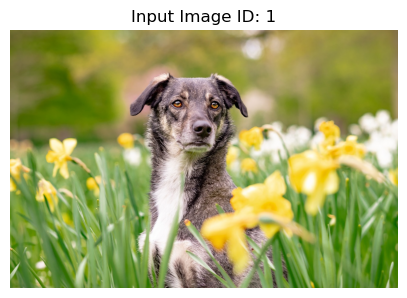

In [12]:
# Informationen des Eingabebildes aus der CSV-Datei abrufen
input_image_info = images[images['image_id'] == image_ids[0]].iloc[0]
input_image_path = os.path.join(input_image_info['root'], input_image_info['file'])
input_image_title = f"Input Image ID: {image_ids[0]}"

show_image(input_image_path, input_image_title)

In [27]:
# Informationen des ähnlichsten Bildes (außer dem Eingabebild) aus der CSV-Datei abrufen
closest_image_id = closest_image_ids[4]
closest_score = closest_vectors[4]
closest_image_info = images[images['image_id'] == closest_image_id].iloc[0]

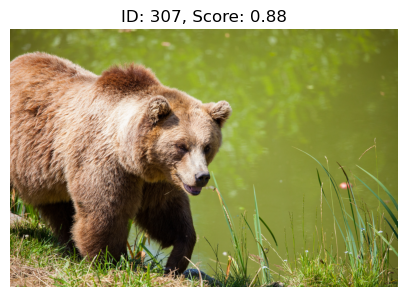

In [28]:
# Bildpfad und Titel sammeln
image_path = os.path.join(closest_image_info['root'], closest_image_info['file'])
title = f"ID: {closest_image_id}, Score: {closest_score:.2f}"

# Bild anzeigen
show_image(image_path, title)